In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import sys, os, subprocess

import swap

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline

/home/oxymoronic/.local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def fetch_parameters(config):

    # Open Configuration File 
    p = swap.Configuration(config)
    params = p.parameters

    return params

In [3]:
def fetch_classifications(filename):
   
    try:
        dat = Table.read(filename,format='ascii')
    except:
        print "Did not find %s"%filename
        sys.exit()
    else:
        return dat

In [4]:
def fetch_filelist(params, kind='detected'):
     
    # ------------------------------------------------------------------
    # Load up detected subjects... 
    #print "Fetching list of %s files created by GZX..."%kind

    try:
        cmd = "ls %s_*/*%s_catalog.txt"%(params['survey'], kind)
        cmdout = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
        filelist = cmdout.stdout.read().splitlines()
        
    except:
        print "No '%s' files found! Aborting..."%kind
        print ""
        sys.exit()
        
    return filelist

In [5]:
def plot_num_classifications_to_retire(detected_file, rejected_file, GZ2_data, 
                                        config, featornot=False):

    GZ2 = GZ2_data['total_classifications']

    detected = fetch_classifications(detected_file)
    rejected = fetch_classifications(rejected_file)
    
    num_detected = detected['Nclass']
    num_rejected = rejected['Nclass']

    num_total = np.concatenate([num_rejected, num_detected])

    # -------------------------------------------------------------------------
    # I want to show how the individual components compare to the whole by 
    # displaying the proportional frequency of classifications. 
    # To do this, I need to pad the detected/rejected arrays so that they're 
    # lengths match the length of the total. Pad them with -1 so that they won't
    # show up in the histogram which will start at 0. 
    
    num_det = np.concatenate([num_detected, np.full(len(num_rejected), -1, dtype='int64')])
    num_rej = np.concatenate([num_rejected, np.full(len(num_detected), -1, dtype='int64')])
    

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    binsize=1
    swapbins = np.arange(np.min(num_total), np.max(num_total), binsize)
    # force the bin sizes for the retired subjects (individually) to start at 0
    retbins = np.arange(0, np.max(num_total), binsize)
    gz2bins = np.arange(np.min(GZ2), np.max(GZ2), binsize)

    weights=np.ones_like(num_total)*1.0/len(num_total)

    #ax.hist(num_total, bins=swapbins, weights=weights, color='purple', 
    #        histtype='stepfilled', alpha=1, edgecolor='purple', label='SWAP')

    if featornot:
        labels = ["'Feat' (%i)"%len(num_detected),"'Not' (%i)"%len(num_rejected)]
        colors = ['yellow', 'blue']
    else:
        labels = ["'Smooth' (%i)"%len(num_detected),"'Not' (%i)"%len(num_rejected)]
        colors = ['blue','yellow']


    ax.hist(num_det, weights=weights, bins=retbins, range=(0,50), color=colors[0],
            histtype='stepfilled', alpha=.5, label=labels[0])

    ax.hist(num_rej, weights=weights, bins=retbins, range=(0,50), color=colors[1],
            histtype='stepfilled', alpha=.5, label=labels[1])

    weights=np.ones_like(GZ2)*1.0/len(GZ2), 
    ax.hist(GZ2, bins=gz2bins, weights=weights, color='green', 
            histtype='stepfilled', alpha=0.5, label='Original GZ2')

    ax.set_ylim(0,.2)
    ax.set_xlim(0,60.)
    ax.set_xlabel('Classifications till retirement', fontsize=16, weight='bold')
    ax.set_ylabel('Frequency', fontsize=16, weight='bold')
    ax.legend(loc='best')

    plt.savefig('classifications_till_retirement_%s.png'%(config['survey']))
    plt.show()

In [6]:
metadata = Table.read('metadata_ground_truth_labels.fits')

In [7]:
def plot_all_the_things(filename, day):
    featornot = False
    
    params = fetch_parameters(filename)  
    
    detectedfilelist = fetch_filelist(params, kind='detected')
    rejectedfilelist = fetch_filelist(params, kind='rejected')
    
    if "flipfeature" in filename:
        featornot = True

    plot_num_classifications_to_retire(detectedfilelist[day], 
                                       rejectedfilelist[day],
                                       metadata, params, 
                                       featornot=featornot) 

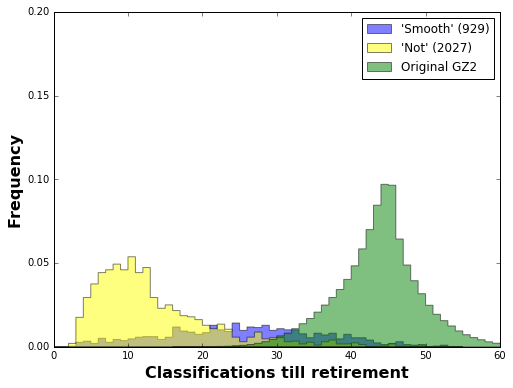

In [10]:
filenames = {'S_standard':'update_sup_0.5_trainfirst_standard2.config', 
             'SU_standard':'update_sup_unsup_0.5_trainfirst_standard2.config',
             'S_featornot':'update_sup_0.5_trainfirst_flipfeature2.config',
             'SU_featornot':'update_sup_unsup_0.5_trainfirst_flipfeature2.config',
             'S_standard_p5':'update_sup_PLPD5_p5_standard2.config'}
interact(plot_all_the_things, filename=filenames, 
         day=widgets.IntSlider(min=0,max=13,step=1,value=5));